In [ ]:
# Start writing code here...

### Note When PyCaret Setup function is called it expects user input and will wait for you to conform if the feature types inferred are corect.

In [ ]:
#!mlflow ui -p 5555

In [ ]:
#!pip install pycaret[full] 
#Restart kernel

In [ ]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from  sklearn.svm import SVR

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression



from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import xgboost
from xgboost import XGBRegressor

from lib.viz import draw_histogram, create_silhoutte_cluster_viz
from lib.unsupervised import kmeans_parameters_search

from lib.supervised_tuning import FeatureTTRegressor, final_comparison, add_cluster_label, print_scores, predict_score_base_regressors, predict_mean_squared_error_regression, read_target_shifted_data, read_target_shifted_pca_data

from matplotlib import pyplot as plt
from xgboost import plot_importance

%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [ ]:
RANDOM_SEED = 42

## Load numpy arrays and dataframes from pickle files

In [ ]:
data_dir = "../assets/train_test_target_shifted/"
train_test_dict_file_name = "train_test_dict_target_shifted.pickle"
X_train_df_file_name = "X_train_impute_target_shifted_df.pkl"
X_test_df_file_name = "X_test_impute_target_shifted_df.pkl"

train_test_dict, X_train_impute_df, X_test_impute_df = read_target_shifted_data(
    data_dir, train_test_dict_file_name, X_train_df_file_name, X_test_df_file_name
)
X_train_impute = train_test_dict["X_train_impute"]
X_test_impute = train_test_dict["X_test_impute"]
y_train = train_test_dict["y_train"]
y_test = train_test_dict["y_test"]


## [Understand the distribution of the target](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [ ]:
draw_histogram(pd.DataFrame(y_train.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

## [Normalize the target to improve accuracy](https://anshikaaxena.medium.com/how-skewed-data-can-skrew-your-linear-regression-model-accuracy-and-transfromation-can-help-62c6d3fe4c53)




In [ ]:
#We will view the variables with sqrt applied but we do not need these in the model since 
# we will be using TransformedTargetRegressor to wrap models to aid with Cross Validations
y_train_sqrt = np.sqrt(train_test_dict['y_train'])
y_test_sqrt = np.sqrt(train_test_dict['y_test'])
draw_histogram(pd.DataFrame(y_train_sqrt.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

#### Crop Code to Crop Name mapping

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

### PyCaret Experimentations

Pycaret Full overrides the currently set libraries in the Docker container.
If placed in the reuirements.txt file, the project takes very long to start up and so this library is only installed for this notebook for all the experimentations.

1. Start the machine/project
2. Run pip install for pycaret[full]   [This can take anywhere from 10 mins to 20 mins)
3. Once the library is installed, restart the kernel for the notebook.
4. Run the cells above once again.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


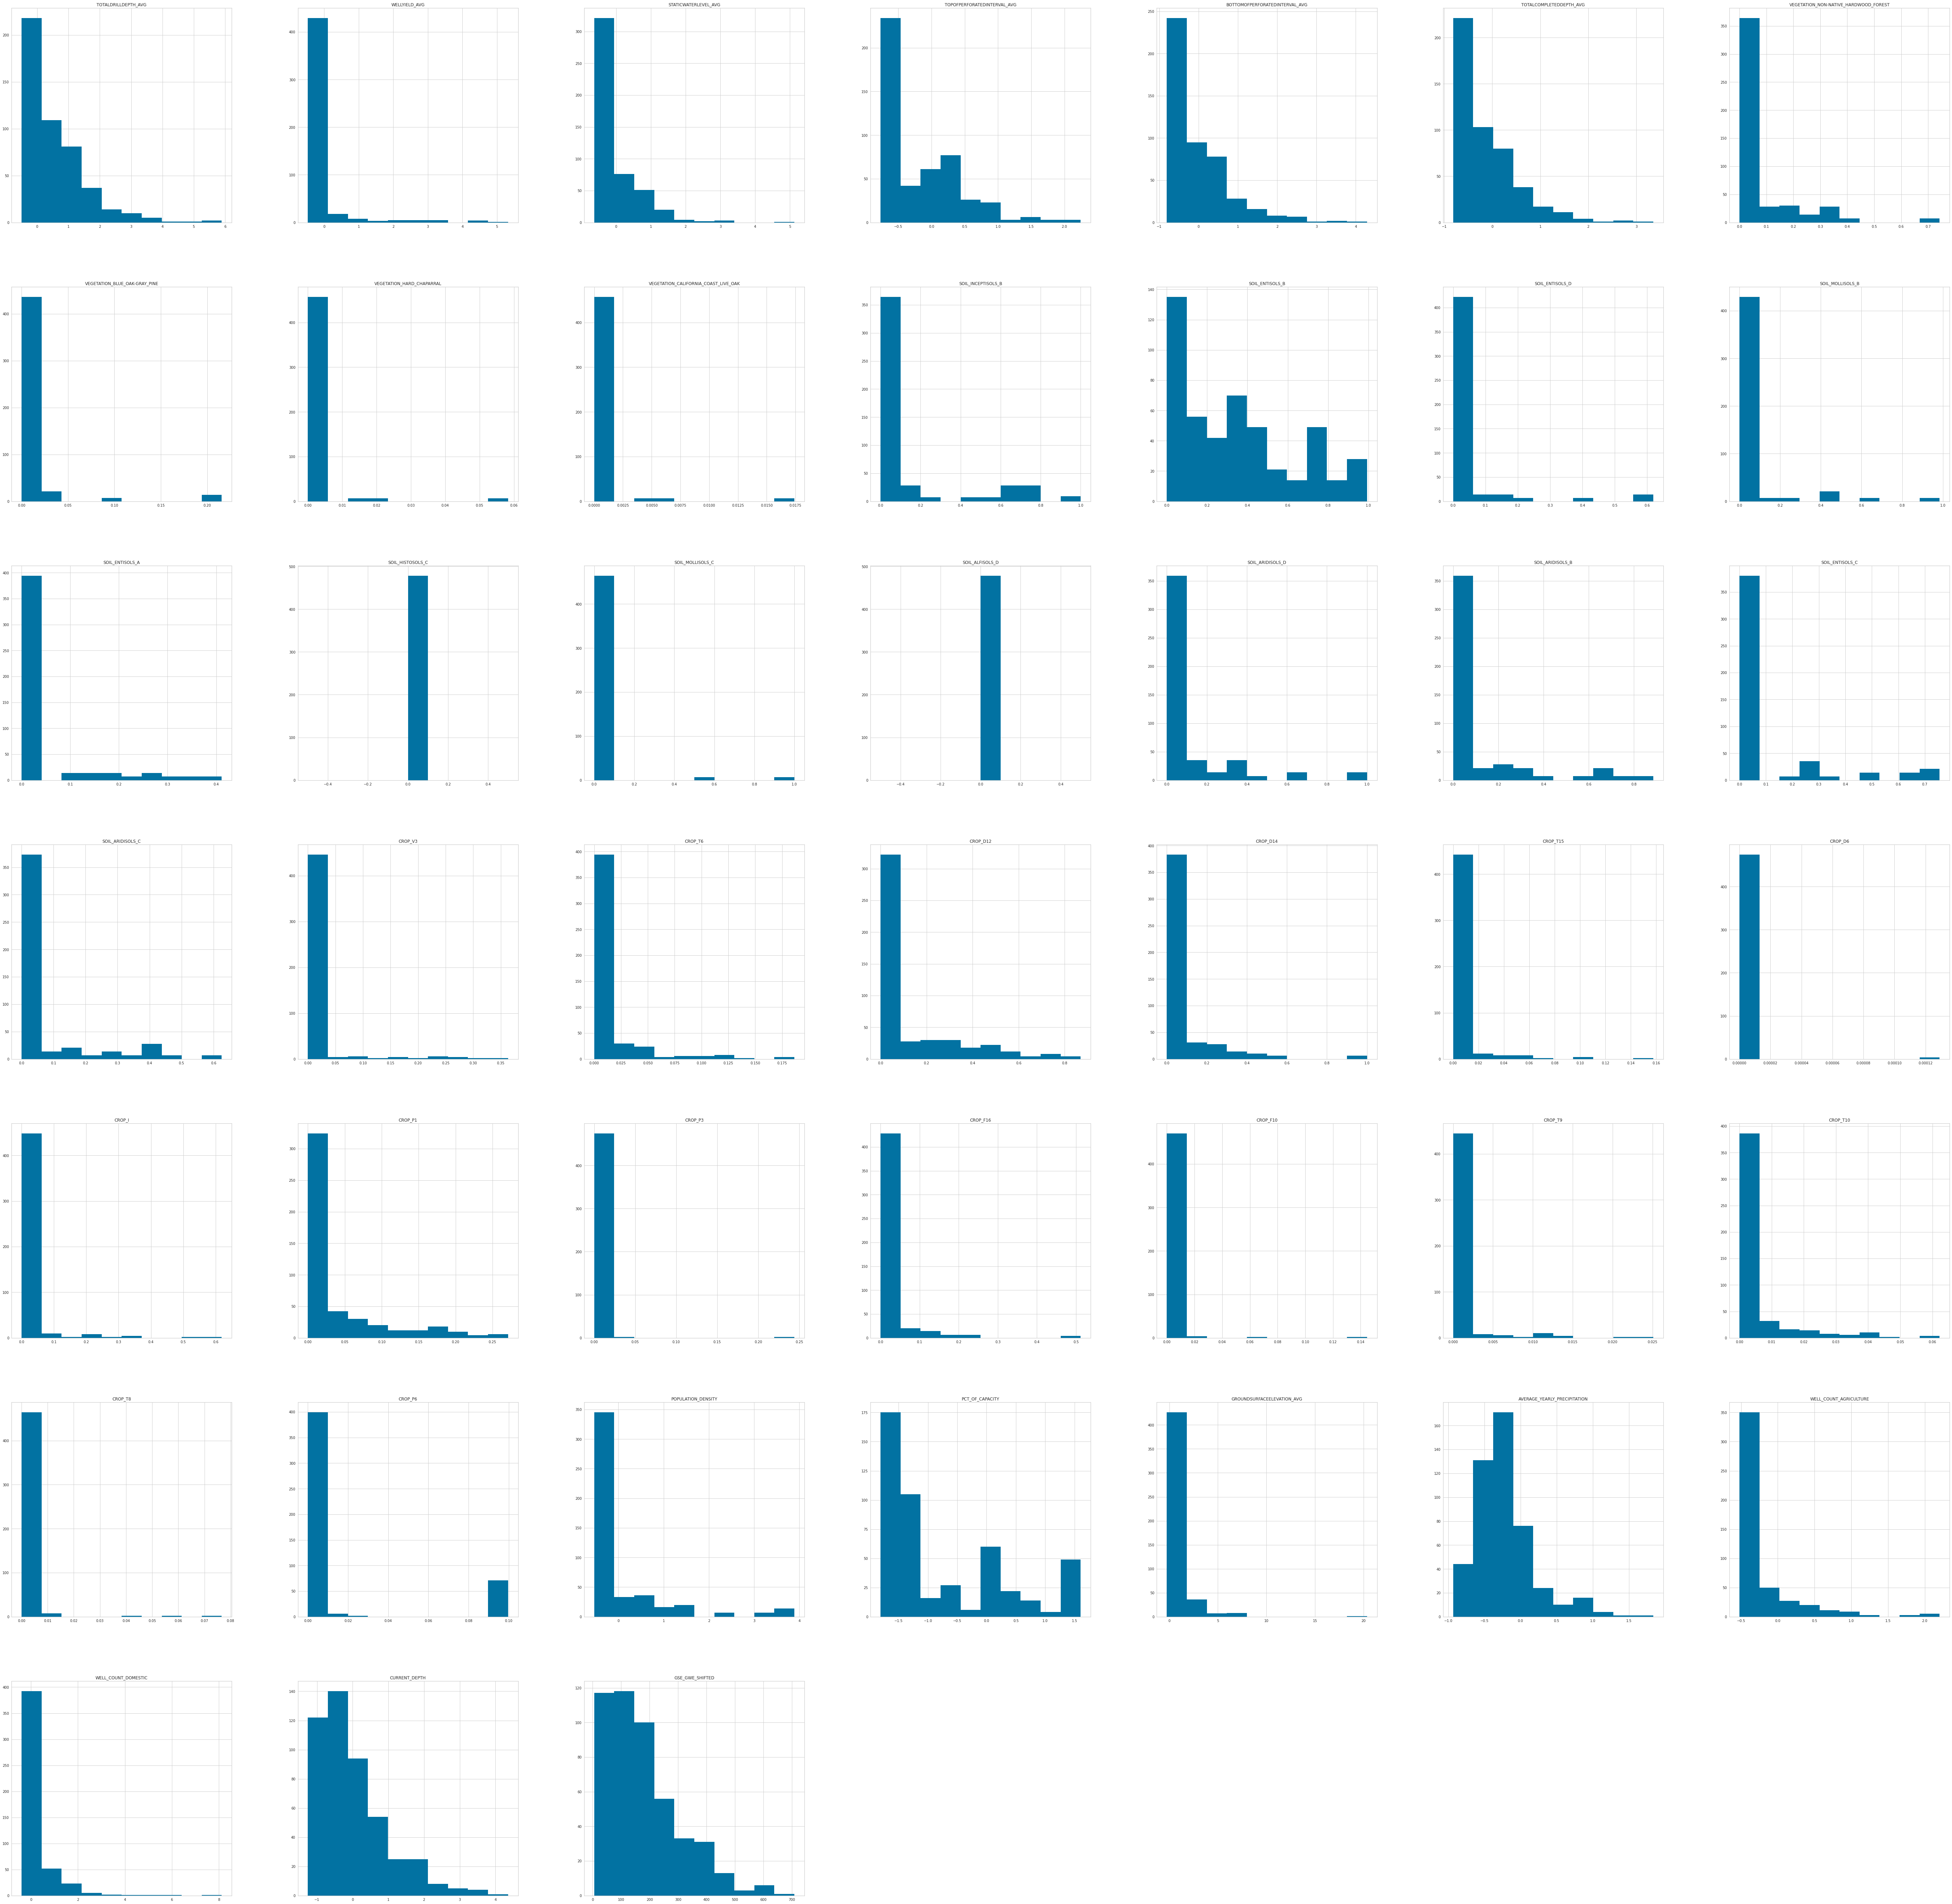

In [ ]:
#This might need restart of the kernel
from pycaret.regression import *

train_data = pd.concat([X_train_impute_df, y_train], axis=1)
test_data = pd.concat([X_test_impute_df, y_test], axis=1)
_= test_data.hist(figsize=(100,100))

#### Run PyCaret experiment  by ignoring low variance and remove multi-collinearity

In [ ]:
# We already have an imputed and scaled train and test, we do not want to preprocess
target_normalized_exp = setup(
    train_data,
    target="GSE_GWE_SHIFTED",
    preprocess=False,
    #Transform the target
    transform_target= True,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.1,
    #Low Variance in feature
    ignore_low_variance=True,
    train_size=1.0,
    test_data=test_data,
    session_id=RANDOM_SEED,
    log_experiment=True,
    experiment_name="water_depth_shifted",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE_SHIFTED
2,Original Data,"(2868, 45)"
3,Missing Values,False
4,Numeric Features,44
5,Categorical Features,0
6,Transformed Train Set,"(2868, 44)"
7,Transformed Test Set,"(478, 44)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 262, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 341, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/venv/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/work/milestone2_waterwells_deepnote/ml/mlruns/mlruns/meta.yaml' does not exist.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_ty

In [ ]:
compare_best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,29.1739,3061.7447,50.0258,0.7717,0.3124,0.2433,1.0270
catboost,CatBoost Regressor,31.3981,3336.0318,51.8299,0.7579,0.3312,0.2761,12.6100
rf,Random Forest Regressor,31.0460,3275.4437,52.0867,0.7490,0.3218,0.2509,3.3380
lightgbm,Light Gradient Boosting Machine,32.5746,3475.3938,53.7225,0.7415,0.3289,0.2678,0.3600
et,Extra Trees Regressor,32.6958,3751.0870,55.2047,0.7265,0.3367,0.2679,1.9300
xgboost,Extreme Gradient Boosting,34.2511,3790.9934,55.3738,0.7217,0.3357,0.2669,1.1350
ada,AdaBoost Regressor,40.8527,4772.9730,61.3466,0.6659,0.4250,0.4345,0.3400
lr,Linear Regression,38.6800,4199.1017,60.1087,0.6485,0.4316,0.4231,0.4490
ridge,Ridge Regression,38.8160,4317.8579,60.7400,0.6452,0.4248,0.4370,0.0180
br,Bayesian Ridge,38.8531,4320.7928,60.7649,0.6450,0.4256,0.4395,0.0260


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

### Narrow down the algorithms using above comparison. algorithms with MAE less than 40 or close to 40 have been chosen from above list

In [ ]:
pick_best_model = compare_models(['gbr', 'catboost', 'et', 'lightgbm', 'rf', 'knn', 'xgboost',  'svm', 'ada', 'lr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,29.1739,3061.7447,50.0258,0.7717,0.3124,0.2433,1.0290
catboost,CatBoost Regressor,31.3981,3336.0318,51.8299,0.7579,0.3312,0.2761,12.3800
rf,Random Forest Regressor,31.0460,3275.4437,52.0867,0.7490,0.3218,0.2509,3.2980
lightgbm,Light Gradient Boosting Machine,32.5746,3475.3938,53.7225,0.7415,0.3289,0.2678,0.3670
svm,Support Vector Regression,32.4098,3472.7730,53.2588,0.7413,0.3631,0.3318,0.4330
et,Extra Trees Regressor,32.6958,3751.0870,55.2047,0.7265,0.3367,0.2679,1.8380
xgboost,Extreme Gradient Boosting,34.2511,3790.9934,55.3738,0.7217,0.3357,0.2669,1.1070
ada,AdaBoost Regressor,40.8527,4772.9730,61.3466,0.6659,0.4250,0.4345,0.3390
lr,Linear Regression,38.6800,4199.1017,60.1087,0.6485,0.4316,0.4231,0.0210
knn,K Neighbors Regressor,44.9301,4460.1374,62.9773,0.6179,0.4858,0.5561,0.0580


INFO:logs:create_model_container: 29
INFO:logs:master_model_container: 29
INFO:logs:display_container: 3
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [ ]:
best_model_created = create_model(pick_best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8490,322.3431,17.9539,0.8608,0.2853,0.2364
1,12.8234,529.4698,23.0102,0.8423,0.2826,0.2002
2,15.2328,782.2523,27.9688,0.7722,0.2914,0.2398
3,35.2767,3235.0286,56.8773,0.8622,0.3797,0.2702
4,26.7293,1710.7049,41.3607,0.8743,0.3578,0.3861
5,39.6708,6283.8722,79.2709,0.6514,0.3175,0.2156
6,26.8546,1953.3921,44.1972,0.8812,0.1976,0.1478
7,30.5809,1877.3262,43.3281,0.7708,0.2265,0.1631
8,51.9841,8117.5145,90.0973,0.7118,0.3087,0.2353


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 4
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [ ]:
best_gbr_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8490,322.3431,17.9539,0.8608,0.2853,0.2364
1,12.8234,529.4698,23.0102,0.8423,0.2826,0.2002
2,15.2328,782.2523,27.9688,0.7722,0.2914,0.2398
3,35.2767,3235.0286,56.8773,0.8622,0.3797,0.2702
4,26.7293,1710.7049,41.3607,0.8743,0.3578,0.3861
5,39.6708,6283.8722,79.2709,0.6514,0.3175,0.2156
6,26.8546,1953.3921,44.1972,0.8812,0.1976,0.1478
7,30.5809,1877.3262,43.3281,0.7708,0.2265,0.1631
8,51.9841,8117.5145,90.0973,0.7118,0.3087,0.2353


INFO:logs:create_model_container: 31
INFO:logs:master_model_container: 31
INFO:logs:display_container: 5
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [ ]:
tuned_model = tune_model(best_gbr_model, choose_better=True)
#                    MAE    MSE         RMSE     R2      RMSLE   MAPE          
#With fold=51 Mean	27.3396	2500.5448	42.5812	0.7668	0.2940	0.2482
#With no fold Mean	29.1872	2945.1679	49.1265	0.7782	0.3208	0.2643

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.4243,376.0859,19.3929,0.8376,0.2951,0.2528
1,16.7705,623.5044,24.9701,0.8143,0.3155,0.2554
2,19.6040,1037.9425,32.2171,0.6977,0.3264,0.2780
3,39.3843,3380.9066,58.1456,0.8560,0.3919,0.2849
4,27.0192,1643.2701,40.5373,0.8793,0.3498,0.3672
5,44.9973,6701.3350,81.8617,0.6283,0.3423,0.2649
6,29.6478,2098.1594,45.8057,0.8724,0.2089,0.1604
7,33.6827,2103.7132,45.8663,0.7432,0.2368,0.1741
8,59.1740,9638.1261,98.1740,0.6578,0.3362,0.2665


INFO:logs:create_model_container: 33
INFO:logs:master_model_container: 33
INFO:logs:display_container: 6
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [ ]:
#get_config('X_train').columns

In [ ]:
# The tuned model does not as good a mean absolute error as best model and so
#sticking with best model from compare
print(best_gbr_model)

PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_split=None,
                                                                 

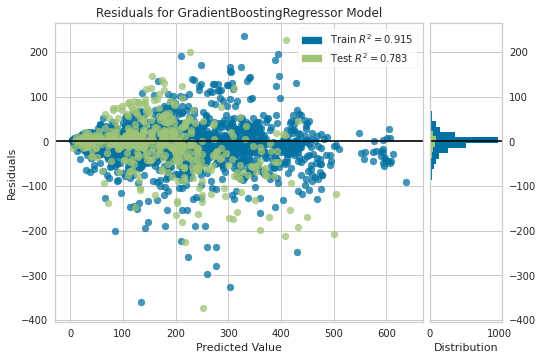

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best_gbr_model, plot='residuals') 

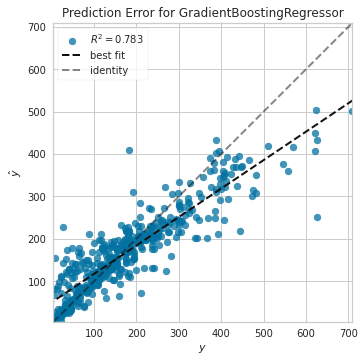

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best_gbr_model, plot='error') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.0556,326.2002,18.0610,0.8592,0.3203,0.2851
1,12.1098,436.3459,20.8889,0.8701,0.2936,0.2281
2,16.0586,845.9057,29.0845,0.7536,0.3338,0.2988
3,33.6648,2944.9477,54.2674,0.8745,0.3802,0.2600
4,27.4759,1686.3073,41.0647,0.8761,0.4093,0.5003
5,40.6946,6285.0694,79.2784,0.6514,0.3178,0.2249
6,27.9946,2012.7988,44.8642,0.8776,0.1979,0.1492
7,28.7467,1755.7019,41.9011,0.7857,0.2052,0.1439
8,52.2620,7465.4096,86.4026,0.7350,0.2818,0.2065


INFO:logs:create_model_container: 36
INFO:logs:master_model_container: 36
INFO:logs:display_container: 8
INFO:logs:PowerTransformedTargetRegressor(border_count=254, depth=5, eta=0.05,
                                l2_leaf_reg=200, loss_function='RMSE',
                                n_estimators=280,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42, random_strength=0.5,
                                regressor=<catboost.core.CatBoostRegressor object at 0x7f1bfceec370>,
                                task_type='CPU', verbose=False)
INFO:logs:tune_model() succesfully completed......................................
INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=PowerTransformedTargetRegressor(border_count=254, depth=5, eta=0.05,
                                l2_leaf_reg=200, loss_function='RMSE',
                       

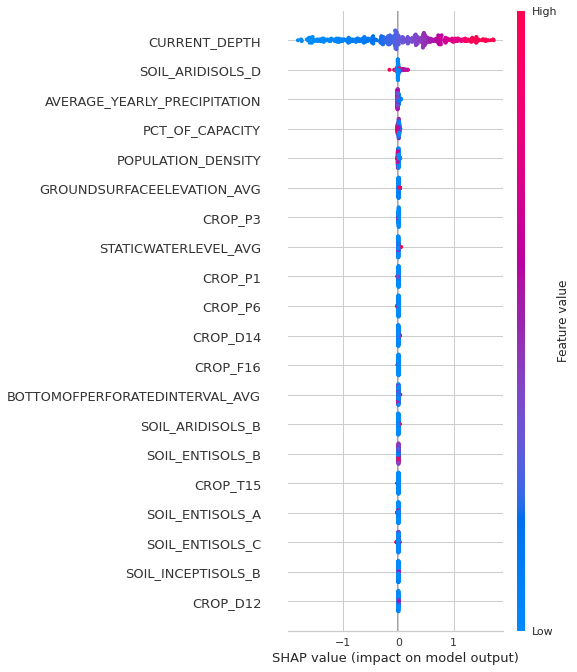

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [ ]:
best_cat_model = create_model('catboost')
tuned_cat_model = tune_model(best_cat_model, choose_better=True)
interpret_model(tuned_cat_model)

#### PyCaret experiments with PCA, target transformations, low variance
#### Use PCA components to train

These are the components that StandardScaling creates which explain 70% of the variance in the data. 

#### Top 4 most important features in each component
===============================================
-Component 0: ['TOTALCOMPLETEDDEPTH_AVG', 'BOTTOMOFPERFORATEDINTERVAL_AVG', 'TOPOFPERFORATEDINTERVAL_AVG', 'STATICWATERLEVEL_AVG']
-Component 1: ['WELL_COUNT_DOMESTIC', 'CURRENT_DEPTH', 'GROUNDSURFACEELEVATION_AVG', 'WELL_COUNT_AGRICULTURE']
-Component 2: ['PCT_OF_CAPACITY', 'AVERAGE_YEARLY_PRECIPITATION', 'WELL_COUNT_AGRICULTURE', 'WELL_COUNT_DOMESTIC']
-Component 3: ['AVERAGE_YEARLY_PRECIPITATION', 'GROUNDSURFACEELEVATION_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_DOMESTIC']
-Component 4: ['TOTALDRILLDEPTH_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_AGRICULTURE', 'GROUNDSURFACEELEVATION_AVG']
-Component 5: ['POPULATION_DENSITY', 'TOTALDRILLDEPTH_AVG', 'PCT_OF_CAPACITY', 'CURRENT_DEPTH']

In [ ]:
data_dir  = '../assets/train_test_target_shifted/'
file_name = 'X_target_shifted_pca.pickle'
pca_train_test_dict = read_target_shifted_pca_data(data_dir, file_name)

   
X_train_standardscaler_pca = pca_train_test_dict["X_train_pca"]
X_test_standardscaler_pca = pca_train_test_dict["X_test_pca"]

arr_train_y = y_train.values.reshape(y_train.values.shape[0], 1)
arr_test_y = y_test.values.reshape(y_test.values.shape[0], 1)

pca_train_standardscaler_df = pd.DataFrame(
    np.hstack((X_train_standardscaler_pca, arr_train_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "GSE_GWE_SHIFTED",
    ],
)
pca_test_standardscaler_df = pd.DataFrame(
    np.hstack((X_test_standardscaler_pca, arr_test_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "GSE_GWE_SHIFTED",
    ],
)


In [ ]:
target_normalized_exp = setup(
    pca_train_standardscaler_df,
    target="GSE_GWE_SHIFTED",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=pca_test_standardscaler_df,
    session_id=RANDOM_SEED,
    log_experiment=True,
    pca=True,
    pca_components=6,
    pca_method="linear",
    experiment_name="water_depth_pca_shifted"
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE_SHIFTED
2,Original Data,"(2868, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Transformed Train Set,"(2868, 6)"
7,Transformed Test Set,"(478, 6)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


INFO:logs:Logging experiment in MLFlow
Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 262, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 341, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/venv/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/work/milestone2_waterwells_deepnote/ml/mlruns/mlruns/meta.yaml' does not exist.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
         

In [ ]:
pca_standardscaler_best = compare_models(['gbr', 'catboost', 'et', 'rf'],fold=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,41.2860,3837.3314,59.2621,0.6313,0.4746,0.5111,3.0447
et,Extra Trees Regressor,43.4020,4044.8160,60.6818,0.6266,0.4962,0.5518,0.5387
rf,Random Forest Regressor,44.4357,4318.3015,62.5989,0.6029,0.5026,0.5537,1.0713
gbr,Gradient Boosting Regressor,46.5065,4510.2098,64.2124,0.5778,0.5249,0.5914,0.4767


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=<catboost.core.CatBoostRegressor object at 0x7f1bfcc41ac0>,
                                task_type='CPU', verbose=False)
INFO:logs:compare_models() succesfully completed......................................


### Improve above model with feature interactions

In [ ]:
# We already have an imputed and scaled train and test, we do not want to preprocess
#https://pycaret.gitbook.io/docs/get-started/preprocessing/feature-engineering
feature_interaction_exp = setup(
    train_data,
    target="GSE_GWE_SHIFTED",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=test_data,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.001,
    remove_perfect_collinearity= True,
    #Low Variance in feature
    ignore_low_variance=True,
    session_id=RANDOM_SEED,
    polynomial_features = True,
    polynomial_degree = 3,
    polynomial_threshold = 0.05,
    log_experiment=True,
    experiment_name="water_depth_feature_engg_shifted",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE_SHIFTED
2,Original Data,"(2868, 45)"
3,Missing Values,False
4,Numeric Features,44
5,Categorical Features,0
6,Transformed Train Set,"(2868, 44)"
7,Transformed Test Set,"(478, 44)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


INFO:logs:Logging experiment in MLFlow
Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 262, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 341, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/venv/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/work/milestone2_waterwells_deepnote/ml/mlruns/mlruns/meta.yaml' does not exist.
2022/07/19 16:58:24 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_feature_engg_shifted' does not exist. Creating a new experiment.
Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_sto

In [ ]:
feature_engg_best = compare_models(['gbr', 'lightgbm', 'catboost','et', 'knn', 'lightgbm', 'xgboost', 'rf', 'gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,67.5045,10850.3303,96.3378,0.1173,0.7355,1.1668,4.4970
knn,K Neighbors Regressor,71.7248,11571.7238,101.5740,0.0165,0.7769,1.1707,0.1950
lightgbm,Light Gradient Boosting Machine,70.9867,12083.3810,102.9223,-0.0044,0.7489,1.3617,0.6510
gbr,Gradient Boosting Regressor,74.6296,12478.4339,103.9782,-0.0141,0.7662,1.3041,2.1740
rf,Random Forest Regressor,71.4509,11687.9602,102.0104,-0.0549,0.7679,1.2489,6.6330
xgboost,Extreme Gradient Boosting,76.7390,13168.7916,107.7094,-0.1504,0.7936,1.3719,2.4140


## Analyze Model

In [ ]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3203,10.6056,3.2566,-0.1393,0.3927,0.4724
1,2.0495,7.0807,2.6610,0.3508,0.3234,0.3232
2,1.9698,7.0209,2.6497,0.3589,0.3284,0.3517
3,3.4266,22.3838,4.7312,0.3388,0.3762,0.3282
4,3.5342,24.3345,4.9330,-0.0980,0.4972,0.6874
5,2.2967,10.7511,3.2789,0.5377,0.2405,0.2027
6,1.7160,6.2027,2.4905,0.6874,0.1653,0.1295
7,2.6375,11.6965,3.4200,-0.1793,0.2352,0.1933
8,4.0773,26.6147,5.1589,0.0804,0.3415,0.3174


In [ ]:
tuned_catboost  = tune_model(catboost)

NameError: name 'catboost' is not defined

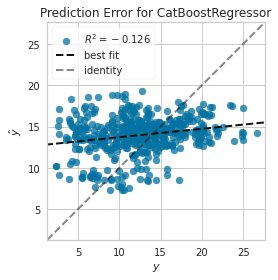

In [ ]:
plot_model(tuned_catboost, plot = 'error')

## Pycaret model search with clustering alone

In [ ]:

train_cluster_data = pd.concat([X_train_cluster_df, y_train], axis=1)
test_cluster_data = pd.concat([X_test_cluster_df, y_test], axis=1)

In [ ]:
from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_cluster_exp = setup(train_cluster_data
                        , target='GSE_GWE_SHIFTED',
                        transform_target=True,
                        train_size=1.0,
                        test_data= test_cluster_data,
                        preprocess=False, session_id=RANDOM_SEED,
                       log_experiment=True, experiment_name="water_depth_cluster_sqrt")

,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 81)"
3,Missing Values,False
4,Numeric Features,80
5,Categorical Features,0
6,Transformed Train Set,"(3346, 80)"
7,Transformed Test Set,"(478, 80)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


2022/06/19 19:35:02 INFO mlflow.tracking.fluent: Experiment with name 'water_depth_cluster_1' does not exist. Creating a new experiment.


In [ ]:
#compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,69.7223,10484.3109,96.0398,0.0746,0.7781,1.5207,4.1300
catboost,CatBoost Regressor,70.9224,11039.9908,99.2784,-0.0234,0.7702,1.5307,24.7910
knn,K Neighbors Regressor,72.3932,11593.2802,102.4067,-0.0258,0.7834,1.3373,0.2100
lightgbm,Light Gradient Boosting Machine,72.2066,12071.8128,103.9338,-0.0831,0.7837,1.6282,0.9020
rf,Random Forest Regressor,73.2270,12109.3941,104.5205,-0.1001,0.7888,1.6185,6.8550
gbr,Gradient Boosting Regressor,76.1096,12004.5654,104.4788,-0.1496,0.8053,1.6578,2.7400
xgboost,Extreme Gradient Boosting,75.6711,12580.2174,105.4749,-0.1697,0.7990,1.5544,2.9430
par,Passive Aggressive Regressor,82.6917,14192.3800,111.3021,-0.1929,0.8594,1.3595,0.0980
huber,Huber Regressor,82.2711,14648.4768,112.7254,-0.2440,0.8933,1.4190,0.2120
ridge,Ridge Regression,85.2479,14124.6868,112.2101,-0.2538,0.9030,1.6377,0.0320


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
#et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.8939,5001.3458,70.7202,-1.2448,1.1751,3.0442
1,30.7736,1573.3535,39.6655,0.5343,0.6821,1.1025
2,43.9926,2870.7455,53.5793,0.2039,0.8703,1.6871
3,94.1808,19251.4637,138.7496,0.1842,0.9652,1.1274
4,81.6478,12129.7407,110.1351,0.0828,1.1078,4.9459
5,70.4018,12583.2866,112.1752,0.3157,0.6488,0.7382
6,52.1317,6113.6455,78.1898,0.6235,0.4246,0.3830
7,69.4657,8826.0057,93.9468,-0.0879,0.4521,0.4159
8,125.6503,26245.9812,162.0061,0.0652,0.7508,0.8789


In [ ]:
#tuned_et  = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63.1174,5563.2368,74.5871,-1.4970,1.3084,3.7380
1,40.7350,2522.7796,50.2273,0.2533,0.8235,1.3598
2,57.1878,4459.1094,66.7766,-0.2365,1.0203,2.1332
3,110.4627,22292.7618,149.3076,0.0553,0.9754,1.4477
4,80.2089,9761.7126,98.8014,0.2618,1.0313,3.6987
5,88.4695,15779.9712,125.6184,0.1419,0.7241,0.8260
6,82.2057,14105.3879,118.7661,0.1314,0.5858,0.5100
7,71.8424,8924.4392,94.4692,-0.1001,0.4530,0.3257
8,144.9801,33482.7577,182.9829,-0.1926,0.8467,0.9799


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


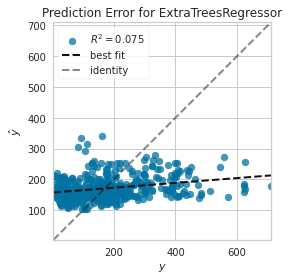

In [ ]:
#plot_model(tuned_et, plot = 'error')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>